_version log: comparing the change in wavelengths as the ROI changes_

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from PIL import Image
import pandas as pd
from scipy import signal, interpolate

pixel_pitch = 9.9 #um

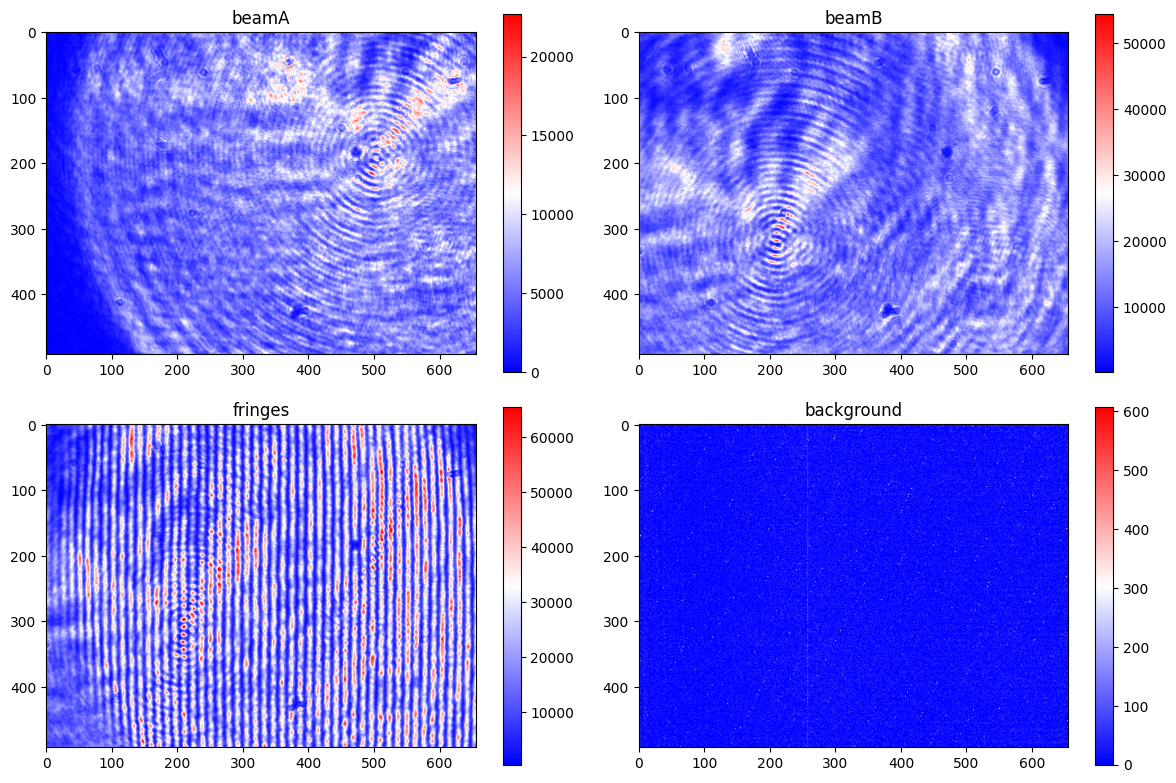

In [2]:
im = Image.open('data\\green_fringes5.tif')
fringes = np.array(im, dtype= np.float32)
im = Image.open('data\\green_BA5.tif')
beamA = np.array(im, dtype= np.float32)
im = Image.open('data\\green_BB5.tif')
beamB = np.array(im, dtype= np.float32)
im = Image.open('data\\green_bg5.tif')
background = np.array(im, dtype= np.float32)

plt.figure(figsize= (12,8))

plt.subplot(2,2,1)
im=plt.imshow(beamA, cmap='bwr')
plt.colorbar(im)
plt.title("beamA")

plt.subplot(2,2,2)
im=plt.imshow(beamB, cmap='bwr')
plt.colorbar(im)
plt.title("beamB")

plt.subplot(2,2,3)
im=plt.imshow(fringes, cmap='bwr')
plt.colorbar(im)
plt.title("fringes")

plt.subplot(2,2,4)
im=plt.imshow(background, cmap='bwr')
plt.colorbar(im)
plt.title("background")

plt.tight_layout()
plt.show()

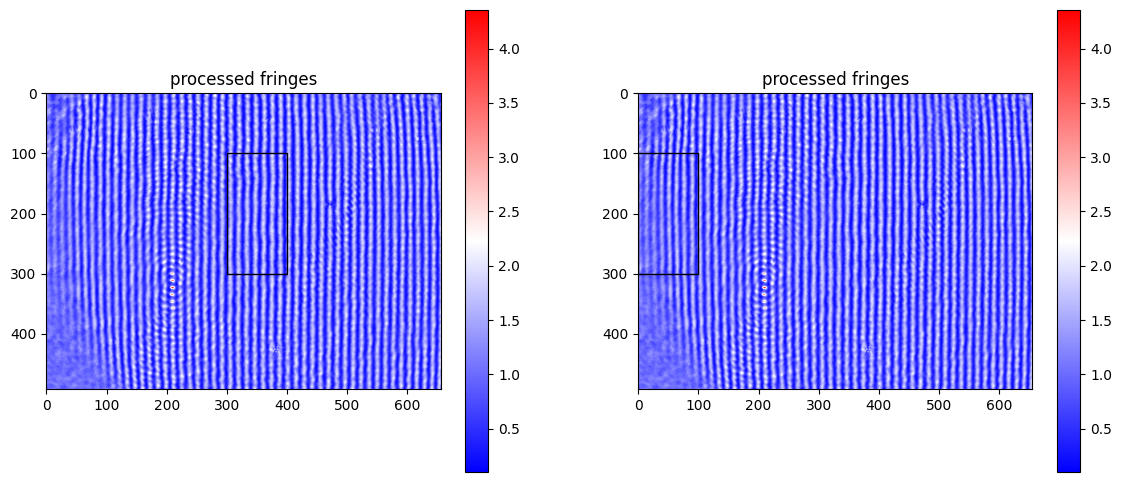

In [3]:
ROI = [[100,300],[300,400]] #region of interest in rows, columns. 
ROI2 = [[100,300],[0,100]]

nofringes = beamA +beamB -background

if False: #toggle which meathod you want to use. IDK which one is better.
    beamPost = fringes - nofringes #take away background. This meathod exaggerates the bandwidth.
else:
    beamPost = fringes / nofringes #normalise using background. This meathod suffers with div0 errors
    beamPost = np.nan_to_num(beamPost, #This is unphysical but so is infinate intensity.
                            posinf= np.nanmax(beamPost[np.isfinite(beamPost)]), #occors for x/0
                            neginf= np.nanmin(beamPost[np.isfinite(beamPost)]), #occors for -x/0. this should be impossible
                            nan= 0) #occors for 0/0

plt.figure(figsize = (14,6))

ax = plt.subplot(1,2,1)
im=plt.imshow(beamPost, cmap='bwr')
plt.colorbar(im)
plt.title("processed fringes")

# Create a Rectangle patch
rect = patches.Rectangle((ROI[1][0], ROI[0][0]), ROI[1][1]-ROI[1][0], ROI[0][1]-ROI[0][0], linewidth=1, edgecolor='k', facecolor='none')
ax.add_patch(rect)

ax = plt.subplot(1,2,2)
im=plt.imshow(beamPost, cmap='bwr')
plt.colorbar(im)
plt.title("processed fringes")

# Create a Rectangle patch
rect = patches.Rectangle((ROI2[1][0], ROI2[0][0]), ROI2[1][1]-ROI2[1][0], ROI2[0][1]-ROI2[0][0], linewidth=1, edgecolor='k', facecolor='none')
ax.add_patch(rect)

plt.show()

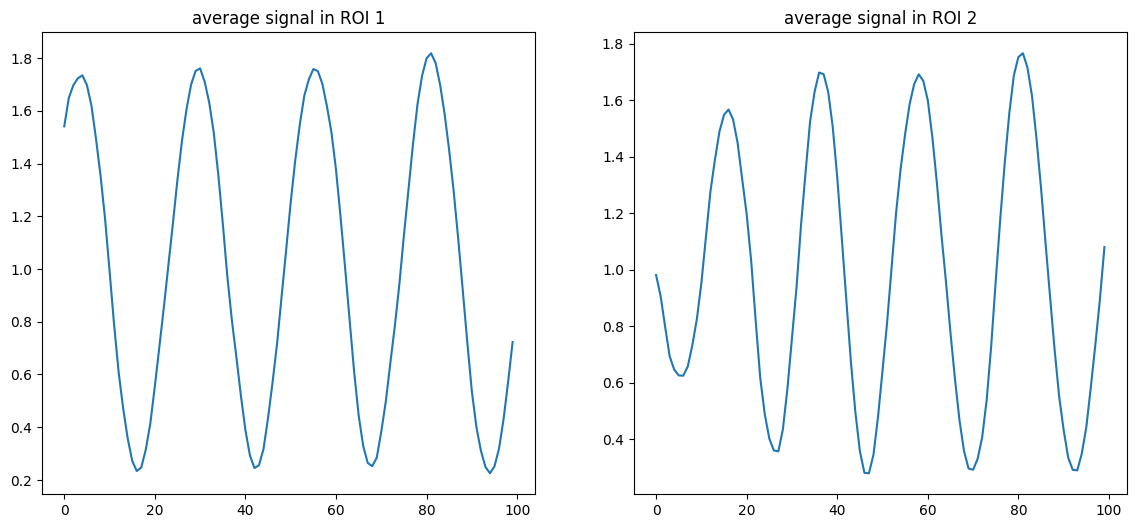

In [13]:
average_signal = np.mean(beamPost[ROI[0][0]:ROI[0][1], ROI[1][0]:ROI[1][1]], axis = 0)
average_signal2 = np.mean(beamPost[ROI2[0][0]:ROI2[0][1], ROI2[1][0]:ROI2[1][1]], axis = 0)

plt.figure(figsize = (14,6))

ax = plt.subplot(1,2,1)
plt.plot(average_signal)
plt.title("average signal in ROI 1")

ax = plt.subplot(1,2,2)
plt.plot(average_signal2)
plt.title("average signal in ROI 2")

plt.show()


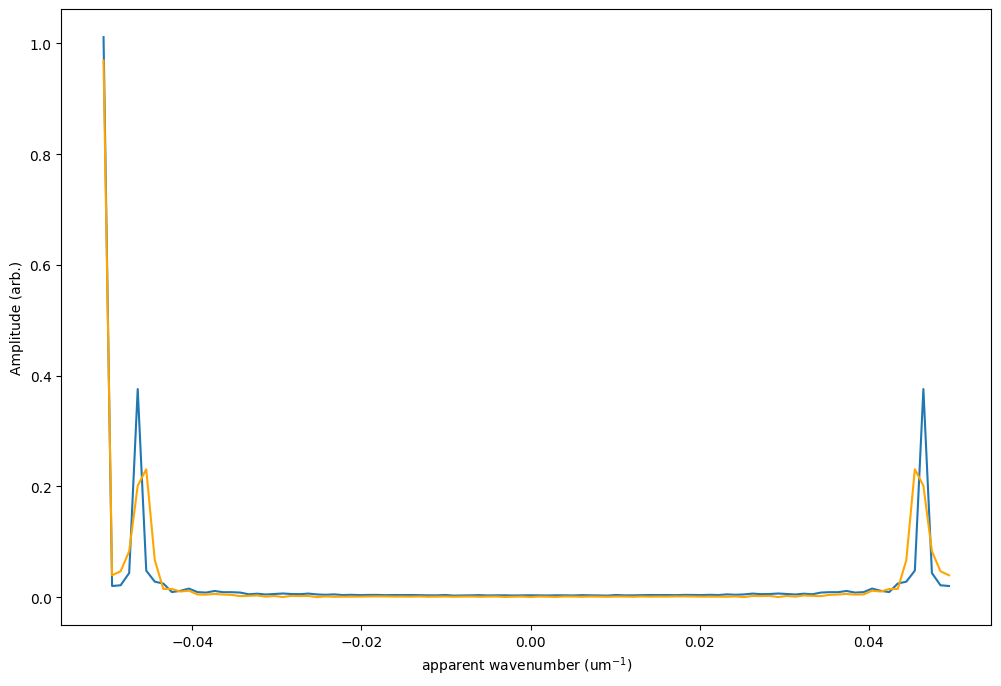

In [16]:
FT = np.fft.fft(average_signal, norm = "forward")
FT2 = np.fft.fft(average_signal2, norm = "forward")

num_of_freqs = len(FT)//2 +1
samples = len(FT)
freqs = np.linspace(-1/2/pixel_pitch, 0, num_of_freqs) #niquist frequency = 1/2 * 1/pixel_pitch
freqs = np.concatenate((freqs, -freqs[-2::-1]))
freqs = freqs[:len(FT)]

plt.figure(figsize = (12,8))

plt.subplot(1, 1, 1)
plt.plot(freqs,
        abs(FT))
plt.plot(freqs,
        abs(FT2),
        color = "orange")
plt.xlabel('apparent wavenumber (um$^{-1}$)')
plt.ylabel('Amplitude (arb.)')

plt.show()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_11164\243399260.py:14: RuntimeWarning: divide by zero encountered in divide
  wavelengths = -1/freqs[:-num_of_freqs +2]


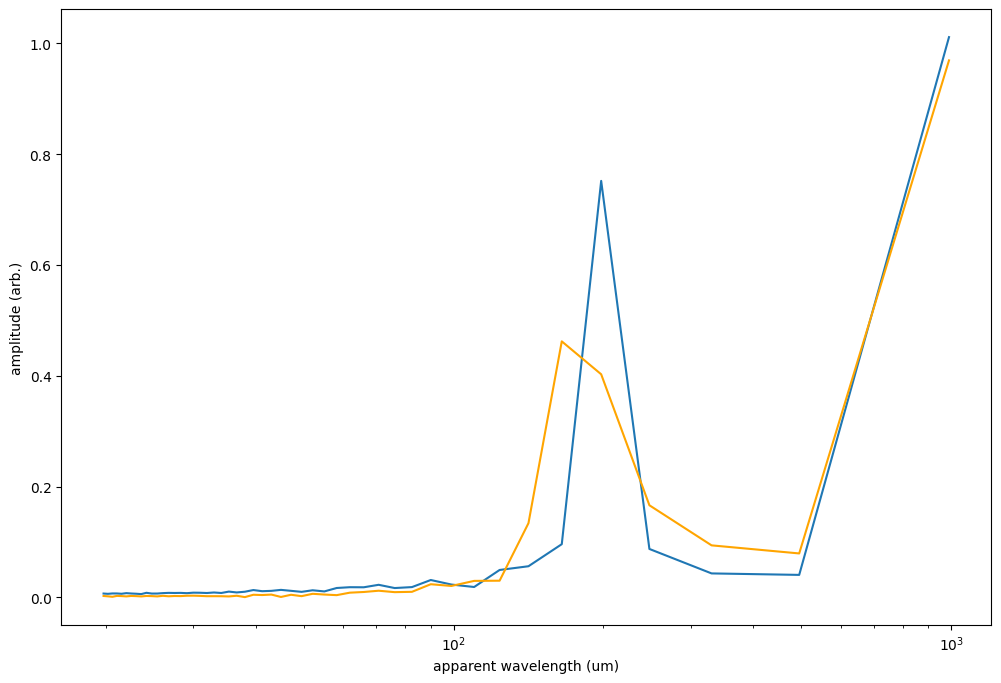

In [17]:
#FT = np.fft.fftshift(FT) #rearranges the array such that 0,0 at the beginning

#assign amplitudes from fft coeffients. Check how elin does this. (She is smarter than me!)
def Coeffients2Amplitudes(FT, num_of_freqs):

        amplitude = np.zeros(num_of_freqs)
        amplitude[0] = np.abs(FT[0])

        if (samples//2 == samples/2): #if even
                amplitude[num_of_freqs-1] = np.abs(FT[num_of_freqs-1])
                amplitude[1:-1] = (np.abs( FT[1:num_of_freqs-1] ) +
                                np.abs( FT[:num_of_freqs-1:-1] ))

                wavelengths = -1/freqs[:-num_of_freqs +2]

        else: #if odd
                amplitude[1:] = (np.abs( FT[1:num_of_freqs] ) +
                                np.abs( FT[:num_of_freqs-1:-1] ))

                wavelengths = -1/freqs[:-num_of_freqs +1]

        amplitude = amplitude[::-1] #the largest wavelength is the smallest frequency so the order needs to be reversed

        return amplitude, wavelengths

amplitude, wavelengths = Coeffients2Amplitudes(FT, num_of_freqs)
amplitude2, wavelengths = Coeffients2Amplitudes(FT2, num_of_freqs)

plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(wavelengths[:-1], #excule the infinate wavelength
        amplitude[1:]) 
plt.plot(wavelengths[:-1], #excule the infinate wavelength
        amplitude2[1:],
        color = "orange") 
plt.xlabel('apparent wavelength (um)')
plt.ylabel('amplitude (arb.)')
plt.xscale("log")
plt.show()

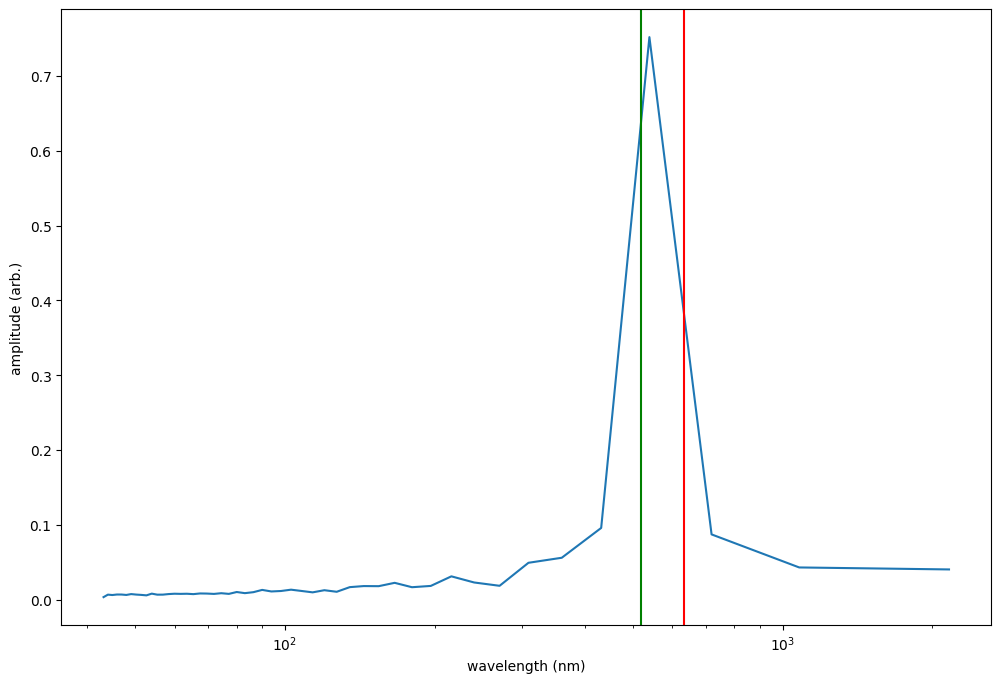

In [8]:
################COMPENSATE FOR ANGLE#################

angle_between_beams = 0.125 # =2*theta. in degrees. Has a large uncertainty

theta = angle_between_beams/2 *np.pi/180 #in radians
corrected_wavelengths = wavelengths *2*np.sin(theta)

plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(corrected_wavelengths[:-1] *1e3, #excule the infinate wavelength and convert to nm
        amplitude[:-1])
plt.xlabel('wavelength (nm)')
plt.ylabel('amplitude (arb.)')
plt.xscale("log")
plt.axvline(520, color = "green")
plt.axvline(635, color = "red")
#plt.xlim(400, 600)
plt.show()

In [9]:
#################FINDING LARGEST AMPLITUDES############

df = np.stack([amplitude,
                corrected_wavelengths])
df = np.transpose(df)

df = pd.DataFrame(df, columns = ["amplitude","wavelength"])
df.sort_values("amplitude", ascending = False, inplace = True)
df.reset_index(drop = True, inplace = True)
df.head(10) #show the top 10 wavelengths

,amplitude,wavelength
0,1.011420,-inf
1,0.751852,0.539961
2,0.095938,0.431969
3,0.087296,0.719948
4,0.056090,0.359974
5,0.049364,0.308549
6,0.043139,1.079922
7,0.040480,2.159845
8,0.031245,0.215984
9,0.023049,0.239983


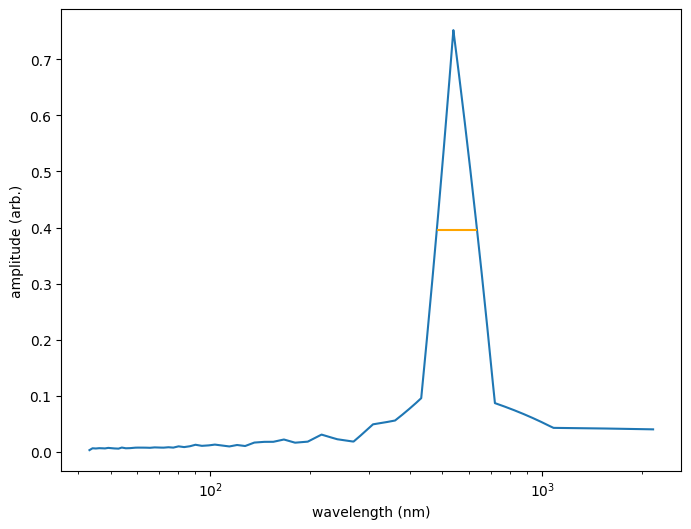

[539.95292284]
[[1.98094621e+02]
 [3.96155777e-01]
 [4.81393556e+02]
 [6.36291287e+02]]


In [10]:
################FINDING FWHM#####################

n = 100_000 #how many liniarlly spaced points to plot. It has to be liniar in order to be able to convert from indexes to um

spectrum_function = interpolate.interp1d(corrected_wavelengths[:-1], amplitude[:-1])
x = np.linspace(corrected_wavelengths[0], corrected_wavelengths[-2], n)
y = spectrum_function(x)

peaks, _ = signal.find_peaks(y, height = 0.1) #height = the smallest peak that can be considered a signal rather than noise. It would be nice to calculate this.
FWHM = signal.peak_widths(y, peaks, rel_height=0.5) #gives the FWHM in terms of indexes
FWHM = np.vstack(FWHM)

peaks = peaks * (corrected_wavelengths[-2] - corrected_wavelengths[0]) /n + corrected_wavelengths[0] #convert to um
FWHM[np.arange(len(FWHM))!=1] = FWHM[np.arange(len(FWHM))!=1] * (corrected_wavelengths[-2] - corrected_wavelengths[0]) /n + corrected_wavelengths[0] #convert to um.
FWHM[np.arange(len(FWHM))!=1] = FWHM[np.arange(len(FWHM))!=1]*1e3 #convert to nm. FWHM[np.arange(len(FWHM))!=1] will exclude index 1 (height of FWHM)

plt.figure(figsize = (8,6))
plt.subplot(1, 1, 1)

plt.plot(x *1e3,
        y)
plt.xlabel('wavelength (nm)')
plt.ylabel('amplitude (arb.)')
plt.xscale("log")
plt.hlines(*FWHM[1:,:], color = "orange")
plt.show()

print(peaks*1e3) # in nm
print(FWHM) # width, height, start, end